# Houston, We Have an Optimization Problem
J. BENNETT, M. DAVIS, Z. MEYER, M. SHIELDS, L. TOLMAN

# Abstract

In this project we attempt to solve an intricate optimal control problem. We want to understand the optimal path (in a two-dimensional world) from a spaceship back to the international space station in a given amount of time. In this scenario, "optimal" means minimizing fuel consumption, which we represent as acceleration. We also make this problem more complex by adding in asteroids that the spaceship must avoid. This traditionally would require inequality constraints, but we will utilize soft constraints instead. We run our solution first without asteroids and then make the problem more complex. We also animate our results to better understand and visualize the optimal path.

# Introduction

Space travel has long fascinated humanity. In recent years, more and more space travel is occurring. Traveling in space presents many different and unique challenges. In our project, we attempt to better understand optimal paths for traveling in space. While we do simplify the problem in many ways (making it two dimensional, ignoring gravity, etc.) we still can learn a lot from optimal paths in our problem. We set up a problem where our spaceship is located at the origin in a two-dimensional world. We then try and find the optimal path back to the space station placed at $(1,1)$. In our most simplified model, we do not have any asteroids in the way. In space where there is no air resistance, once you are traveling a certain velocity you continue to travel at that velocity. This means we can minimize gas consumption by minimizing the acceleration in the $x$ and $y$ direction. This will give us our optimal path. In our first model, with no asteroids in the way, this should result in a straight path back to the space station.

After getting this model to work, we complicate our model by adding asteroids. To avoid an asteroid, we could use inequality constraints with KKT conditions. However, due to the complexities of KKT conditions in optimal control, we can also handle this constraint as a soft constraint. We took the latter approach of adding the constraint into the cost functional. This essentially adds a cost to our functional when the spaceship is too close to the asteroid. We want this cost to vanish quickly when the spaceship is away from the asteroid, so it does not take a very suboptimal path. We also do not want this cost to vanish so quickly that the spaceship gets arbitrarily close to the asteroid. By adding this constraint to our cost functional, when we minimize our cost functional, we will minimize gas consumption and avoid the asteroids. After our first model, we will add an asteroid and find the optimal path. Then we will continue to add asteroids to see how our path changes. Finally, we will make the asteroids move instead of being stationary. 

In all of our models besides the last where we have the nonstationary asteroids, we use the following cost functional and state space.


$$J[u] = \int_0^{t_f} \left [\frac{1}{2}u_{x}(t)^2 + \frac{1}{2}u_{y}(t)^2 + \sum_{i = 1}^n \frac{W_i}{\left (\frac{\left(x(t) - c_x\right)^2}{r_i} + \frac{\left(y(t) - c_y\right)^2}{r_i} \right)^{20}}\right ] dt$$

$$ S = \begin{bmatrix}  x &  y & \dot x & \dot y  \end{bmatrix}  ^T $$

$$ \dot S = \begin{bmatrix} \dot x & \dot y & u_x & u_y  \end{bmatrix}  ^T $$

We use the cost functional defined above. In this cost functional $u_x$ and $u_y$ represent acceleration in the $x$ and $y$ direction. In the summation, $n$ represent the number of asteroids. So, if we do not have any asteroids, the summation does not exist. In the summation part of the cost functional, $W_i$ is the weight of the ith asteroid (the cost of getting too close or hitting the asteroid) and $c_{x_i}$, $c_{y_i}$, and $r_i$ define the center and radius of the ith asteroid. With our cost functional and state space defined we can use Pontryagin’s Maximum Principle to find our costate evolution equations. 

$$ P = \begin{bmatrix}  P_0 &  P_1 & P_2 & P_3  \end{bmatrix}  ^T $$

$$ \dot P = \begin{bmatrix}  C_x &  C_y & -P_0 & -P_1  \end{bmatrix}  ^T$$

Now we have everything we need to solve our optimization problem besides our boundary conditions. Based on the setup of our problem we use the following boundary conditions.

$$ \begin{align*}
        x(0) &= 0 & x(t_f) &= 1\\
        y(0) &= 0 & y(t_f) &= 1\\
        \dot x(0) &= v_x & \dot x(t_f) &= 0\\
        \dot y(0) &= v_y & \dot y(t_f) &= 0\\
    \end{align*} $$

This ensures that our spaceship is starting at the origin and travels to the space station. We are also assuming that our spaceship could have been moving with initial velocities of $v_x$ and $v_y$ in the $x$ and $y$ direction before we begin our optimization problem. We force our spaceship to stop moving once it arrives at the space station.


This gives us everything we need to solve for our optimal path. We will showcase several different situations and amounts of asteroids in the following models. When we adjust the asteroids so that they are moving, we change the cost functional to the following form:

$$J[u] = \int_0^{t_f} \left [\frac{1}{2}u_{x}(t)^2 + \frac{1}{2}u_{y}(t)^2 + \sum_{i = 1}^n \frac{W_i}{\left (\frac{\left(x(t) - c_x(t)\right)^2}{r_i} + \frac{\left(y(t) - c_y(t)\right)^2}{r_i} \right)^{20}}\right ] dt$$

The only difference in this cost functional is that now the asteroids center is a function of time. 

# Models

Before showing code for each model we will showcase some code used in the different models.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from scipy.integrate import solve_bvp
import matplotlib.image as mpimg
from scipy.ndimage import rotate

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


We will use the above imports and packages in our models while solving for the optimal path of the spaceship.

In [2]:
def obstacle(x,y,W1=1,r=(1/5,1/5),c=(1/2,1/2)):
    '''
    Define an area that will represent an asteroid
    
    Parameters:
        x (float): x position in space
        y (float): y position in space
        W1 (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''

    ellipse = ((x - c[0])**2/r[0] + (y - c[1])**2/r[1])**20 + 1

    return W1 / ellipse

def obstacle_dx(x,y,W1=1,r=(1/5,1/5),c=(1/2,1/2)):
    '''
    x derivative of the asteroid

    Parameters:
        x (float): x position in space
        y (float): y position in space
        W (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''

    circle = (x - c[0])**2/r[0] + (y - c[1])**2/r[1]
    numer = -40* W1 * (x-c[0])*(circle)**19
    denom = r[0]*((circle)**20 + 1)**2

    return numer / denom

def obstacle_dy(x,y,W1=1,r=(1/5,1/5),c=(1/2,1/2)):
    '''
    y derivative of the asteroid

    Parameters:
        x (float): x position in space
        y (float): y position in space
        W1 (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''

    circle = (x - c[0])**2/r[0] + (y - c[1])**2/r[1]
    numer = -40 * W1 * (y-c[1])*(circle)**19
    denom = r[1]*((circle)**20 + 1)**2
    
    return numer / denom

The functions above will be used for models 1-7 to define our stationary asteroid obstacles.

In [3]:
def new_obstacle(x,y,t,xspeed,yspeed,W1=1,r=(1/5,1/5),c=(1/2,1/2)):
    '''
    Define an area that will represent an asteroid with a moving center
    
    Parameters:
        x (float): x position in space
        y (float): y position in space
        W1 (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''
    c = (xspeed*t+c[0],yspeed*t+c[1])
    ellipse = ((x - c[0])**2/r[0] + (y - c[1])**2/r[1])**2 + 1

    return W1 / ellipse

def new_obstaclexy(x,y,t,xspeed,yspeed,W1=1,r=(1/5,1/5),c=(1/2,1/2)):
    '''
    Extract the x and y values for the new center of the moving asteroid
    
    Parameters:
        x (float): x position in space
        y (float): y position in space
        W1 (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''
    c = (xspeed*t+c[0],yspeed*t+c[1])

    return c

def new_obstacle_dx(x,y,t,xspeed,yspeed,W1=1,r=(1/5,1/5),c=(1/2,1/2)):
    '''
    x derivative of the asteroid with a moving center

    Parameters:
        x (float): x position in space
        y (float): y position in space
        W (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''
    c = (xspeed*t+c[0],yspeed*t+c[1])
    circle = (x - c[0])**2/r[0] + (y - c[1])**2/r[1]
    numer = -40* W1 * (x-c[0])*(circle)**19
    denom = r[0]*((circle)**20 + 1)**2

    return numer / denom

def new_obstacle_dy(x,y,t,xspeed,yspeed, W1=1,r=(1/5,1/5),c=(1/2,1/2)):
    '''
    y derivative of the asteroid with a moving center

    Parameters:
        x (float): x position in space
        y (float): y position in space
        W1 (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''
    c = (xspeed*t+c[0],yspeed*t+c[1])
    circle = (x - c[0])**2/r[0] + (y - c[1])**2/r[1]
    numer = -40 * W1 * (y-c[1])*(circle)**19
    denom = r[1]*((circle)**20 + 1)**2

    return numer / denom

The functions above will be used for model 8 to define our moving asteroid obstacles.

In [4]:
# Read in rocket image
filepath = "Untitled_Artwork.png"
img = mpimg.imread(filepath)

# Rotate rocket image based on velocity
def rotate_rocket(xv,yv):
    angle = np.degrees(np.arctan2(-xv,yv))
    rotated_img = rotate(img, angle, reshape=False)
    rotated_img = np.clip(rotated_img, 0, 1)
    return rotated_img

The above function and code will be used in our animations to import an image of a rocket. The rocket will also rotate as it turns to make the animation look more realistic.

Note, the following animations take a considerable amount of time to generate, so we suggest only running the first cell of each model to generate a plot of the optimal path.

### Model 1

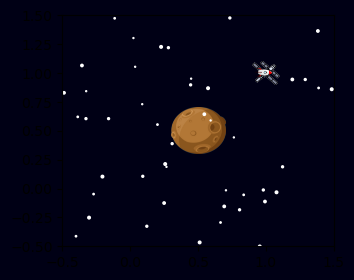

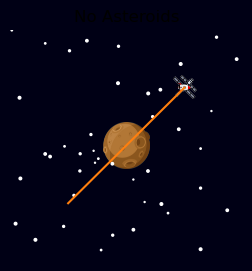

In [19]:
#set initial conditions
t0 = 0
tf = 1

def ode(t, y_val): #define the ode system
    x, y, xp, yp, p0, p1, p2, p3 = y_val
    zeros = np.zeros_like(x)

    return np.array([xp, yp, p2, p3, zeros, zeros, -p0, -p1])

def bc(ya,yb):
# ya are the initial values
# yb are the final values
    return np.array([ya[0],ya[1],ya[2],ya[3],yb[0]-1,yb[1]-1,yb[2],yb[3]])

#set the intial conditions and yo
t_steps = 200
t = np.linspace(t0,tf,t_steps)
x = np.linspace(0,1,t_steps)
y0 = np.ones((8,t_steps))

# Solve the system.
sol = solve_bvp(ode, bc, t, y0)

#plot the solutions and label everything
plt.plot(sol.y[0], sol.y[1])
plt.axis('off')
plt.title('No Asteroids')
plt.show()


This shows the solution to the boundary problem.

In [20]:
# set the size of the rocket
ROCKET_SIZE = .14

plt.ioff()

path_length=len(sol.y[1])
ts = range(path_length+50)
fig = plt.figure()
fig.set_facecolor('#000015')
fig.set_size_inches(3, 3)
ax = fig.add_subplot(111)

ax.set_xlim([-.5,1.5])
ax.set_ylim([-.5,1.5])
ax.set_facecolor('#000015')

path=np.vstack((sol.y[0], sol.y[1])).T
rocketpath, = ax.plot([], [],'w', alpha=0.4)
rocket, = ax.plot([], [], color="#5FC2D9", label='rocket', marker='^', markersize=15)

#plot stars in the background
starx=np.random.uniform(-1,2,size=100)
stary=np.random.uniform(-1,2,size= 100)
sizes=np.random.choice([.5,1,2,3,3.5], size=100)
ax.scatter(starx, stary, s=sizes, color='white')

#read in the image of the space station and place it
space_station = mpimg.imread("space-station.png")
ax.imshow(space_station, extent=[.9,1.1,.9,1.1])

#set the locations for the rocet
xmin, xmax = sol.y[0][0]-ROCKET_SIZE, sol.y[0][0]+ROCKET_SIZE
ymin, ymax = sol.y[1][0]-ROCKET_SIZE, sol.y[1][0]+ROCKET_SIZE
img = mpimg.imread(filepath)

# plot the trajectory
line, = plt.gca().plot([], [], "--", linewidth=3,)

# Plot initial position of the rocket
rocket = plt.imshow(img, extent=[xmin,xmax,ymin,ymax], aspect='auto', zorder=2)

# ax.legend()
def update(t):
    if t<50:
        s=0
        p=t
    elif t>path_length-1:
        p=path_length-1
        s=t-50
    else:
        s=t-50
        p=t
    #update path
    rocketpath.set_data(path[s:p,0],path[s:p,1])
    #update rocket
    rocket.set_data(rotate_rocket(sol.y[2][t],sol.y[3][t]))
    rocket.set_extent([sol.y[0][t] - ROCKET_SIZE, sol.y[0][t] + ROCKET_SIZE, sol.y[1][t] - ROCKET_SIZE, sol.y[1][t] + ROCKET_SIZE])
    
#save and show
ani = FuncAnimation(fig, update, frames=ts[:200][::10], interval=20)
ani.save('simple_example.mp4')


CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '300x300', '-pix_fmt', 'rgba', '-framerate', '50.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'simple_example.mp4']' returned non-zero exit status 255.


<video src="simple_example.mp4" controls>

### Model 2

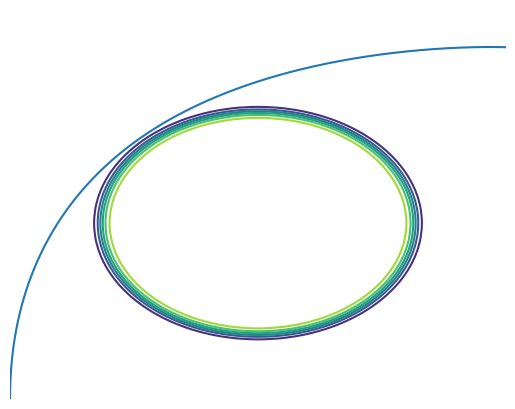

In [34]:
#set initial conditions
t0 = 0
tf = 1
W = 10
r = (.1,.1)

def ode(t, y_val): #define the ode system
    x, y, xp, yp, p0, p1, p2, p3 = y_val
    new_p0 = obstacle_dx(x,y,W,r) #find the new p0 and p1
    new_p1 =  obstacle_dy(x,y,W,r)
    return np.array([xp, yp, p2, p3, new_p0,new_p1, -p0, -p1])

def bc(ya,yb):
    # ya are the initial values
    # yb are the final values
    return np.array([ya[0],ya[1],ya[2],ya[3]-3,yb[0]-1,yb[1]-1,yb[2],yb[3]])


t_steps = 200 #set the time steps and linspaces
t = np.linspace(t0,tf,t_steps)
x = np.linspace(0,1,t_steps)
y = np.linspace(0,1,t_steps)
X,Y = np.meshgrid(x,y)
Z = obstacle(X,Y,W,r) #find Z 
#set the initial guess
y0 = np.ones((8,t_steps))*3
# Solve the system.
sol = solve_bvp(ode, bc, t, y0, max_nodes=30000)

#plot the solutions and label everything
plt.plot(sol.y[0], sol.y[1])
plt.contour(X,Y,Z)
plt.axis('off')
title_obj = plt.title('One Asteroid')
plt.setp(title_obj, color='w')
plt.show()

This finds the solution to the boundary problem.

In [18]:
# plot the rocket
ROCKET_SIZE = .14

plt.ioff()

#get data
path_length=len(sol.y[1])
ts = range(path_length+50)
fig = plt.figure()
fig.set_facecolor('#000015')
fig.set_size_inches(3, 3)
ax = fig.add_subplot(111)

#set limits
ax.set_xlim([-.5,1.5])
ax.set_ylim([-.5,1.5])
ax.set_facecolor('#000015')

#get path
path=np.vstack((sol.y[0], sol.y[1])).T
rocketpath, = ax.plot([], [],'w', alpha=0.4)

#plot rocket
rocket, = ax.plot([], [], color="#5FC2D9", label='rocket', marker='^', markersize=15)

#plot stars
starx=np.random.uniform(-1,2,size=100)
stary=np.random.uniform(-1,2,size= 100)
sizes=np.random.choice([.5,1,2,3,3.5], size=100)
ax.scatter(starx, stary, s=sizes, color='white')

#asteroid dots
asteroid1 = mpimg.imread("meteoroid.png")
c = [1/2,1/2]
r = .2
ax.imshow(asteroid1, extent=[c[0]-r, c[0]+r, c[1]-r, c[1]+r])

#read in the space station
space_station = mpimg.imread("space-station.png")
ax.imshow(space_station, extent=[.9,1.1,.9,1.1])

#set the location of the rocket
xmin, xmax = sol.y[0][0]-ROCKET_SIZE, sol.y[0][0]+ROCKET_SIZE
ymin, ymax = sol.y[1][0]-ROCKET_SIZE, sol.y[1][0]+ROCKET_SIZE
img = mpimg.imread(filepath)

# plot the trajectory
line, = plt.gca().plot([], [], "--", linewidth=3,)

# Plot initial position of the rocket
rocket = plt.imshow(img, extent=[xmin,xmax,ymin,ymax], aspect='auto', zorder=2)

# ax.legend()
def update(t):
    if t<50:
        s=0
        p=t
    elif t>path_length-1:
        p=path_length-1
        s=t-50
    else:
        s=t-50
        p=t

    #update path
    rocketpath.set_data(path[s:p,0],path[s:p,1])

    #update rocket
    rocket.set_data(rotate_rocket(sol.y[2][t],sol.y[3][t]))
    rocket.set_extent([sol.y[0][t] - ROCKET_SIZE, sol.y[0][t] + ROCKET_SIZE, sol.y[1][t] - ROCKET_SIZE, sol.y[1][t] + ROCKET_SIZE])

#save and show
ani = FuncAnimation(fig, update, frames=ts[:950][::10], interval=20)
ani.save('rocket1.mp4')

This compiles the animation.

<video src="rocket1.mp4" controls>

### Model 3

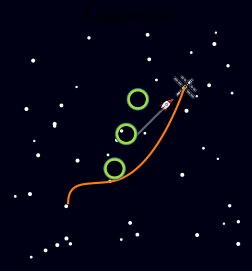

In [21]:
#set the initial conditions
t0 = 0
tf = 1
W = 15000
r = (.007,.007)
#notice we have multiple asteroids
c2 = (.6,.9)
c3 = (.4,.3)
c4 = (.5,.6)

def ode(t, y_val): #define the ode system
    x, y, xp, yp, p0, p1, p2, p3 = y_val
    #get the new p0 and p1
    new_p0 = obstacle_dx(x,y,W,r,c4) + obstacle_dx(x,y,W,r,c2) + obstacle_dx(x,y,W,r,c3)
    new_p1 =  obstacle_dy(x,y,W,r,c4) + obstacle_dy(x,y,W,r,c2) + obstacle_dy(x,y,W,r,c3)
    return np.array([xp, yp, p2, p3, new_p0, new_p1, -p0, -p1])

def bc(ya,yb):
    # ya are the initial values
    # yb are the final values
    return np.array([ya[0],ya[1],ya[2],ya[3]-2,yb[0]-1,yb[1]-1,yb[2],yb[3]])


t_steps = 200 #set the time steps and linspaces
t = np.linspace(t0,tf,t_steps)
x = np.linspace(0,1,t_steps)
y = np.linspace(0,1,t_steps)
X,Y = np.meshgrid(x,y)
#find the obstacles
Z2 = obstacle(X,Y,W,r,c2)
Z3 = obstacle(X,Y,W,r,c3)
Z4 = obstacle(X,Y,W,r,c4)
# set the initial guess.
y0 = np.ones((8,t_steps))*3
# Solve the system.
sol = solve_bvp(ode, bc, t, y0,max_nodes=30000)

#plot the solutions and label everything
plt.plot(sol.y[0], sol.y[1])
plt.contour(X,Y,Z2)
plt.contour(X,Y,Z3)
plt.contour(X,Y,Z4)
plt.axis('off')
plt.title('3 Asteroids')
plt.show()

This finds the solution to the boundary problem.

In [22]:
mypath = sol.y
plt.ioff()
#get data

path_length=len(mypath[1])
tail_length=50
ts = range(path_length+50)
fig = plt.figure()
fig.set_facecolor('#000015')
fig.set_size_inches(3, 3)
ax = fig.add_subplot(111)

#set limits
ax.set_xlim([-.5,1.5])
ax.set_ylim([-.5,1.5])
ax.set_facecolor('#000015')

#get path
path=np.vstack((mypath[0], mypath[1])).T
rocketpath, = ax.plot([], [],'w', alpha=0.4)

#plot rocket
rocket, = ax.plot([], [], color="#5FC2D9", label='rocket', marker='^', markersize=15)

#plot stars
starx=np.random.uniform(-1,2,size=100)
stary=np.random.uniform(-1,2,size= 100)
sizes=np.random.choice([.5,1,2,3,3.5], size=100)
ax.scatter(starx, stary, s=sizes, color='white')

#asteroid dots
asteroid1 = mpimg.imread("meteoroid.png")
r = .07
ax.imshow(asteroid1, extent=[c4[0]-r, c4[0]+r, c4[1]-r, c4[1]+r])
r = .07
ax.imshow(asteroid1, extent=[c2[0]-r, c2[0]+r, c2[1]-r, c2[1]+r])
r = .07
ax.imshow(asteroid1, extent=[c3[0]-r, c3[0]+r, c3[1]-r, c3[1]+r])

#read in the space stations
space_station = mpimg.imread("space-station.png")
ax.imshow(space_station, extent=[.9,1.1,.9,1.1])

#set the locaiton of the rocket
xmin, xmax = sol.y[0][0]-ROCKET_SIZE, sol.y[0][0]+ROCKET_SIZE
ymin, ymax = sol.y[1][0]-ROCKET_SIZE, sol.y[1][0]+ROCKET_SIZE
img = mpimg.imread(filepath)

# plot the trajectory
line, = plt.gca().plot([], [], "--", linewidth=3,)

# Plot initial position of the rocket
rocket = plt.imshow(img, extent=[xmin,xmax,ymin,ymax], aspect='auto', zorder=2)

def update(t):
    if t<tail_length:
        s=0
        p=t
    elif t>path_length-1:
        p=path_length-1
        s=t-tail_length
    else:
        s=t-tail_length
        p=t
    #update path
    rocketpath.set_data(path[s:p,0],path[s:p,1])
    #update rocket
    
    rocket.set_data(rotate_rocket(sol.y[2][t],sol.y[3][t]))
    rocket.set_extent([sol.y[0][t] - ROCKET_SIZE, sol.y[0][t] + ROCKET_SIZE, sol.y[1][t] - ROCKET_SIZE, sol.y[1][t] + ROCKET_SIZE])
#save and show
ani = FuncAnimation(fig, update, frames=ts[:2450][::10], interval=10)
ani.save('rocket_3asteroids.mp4')

This compiles the animation.

<video src="rocket_3asteroids.mp4" controls>

### Model 4

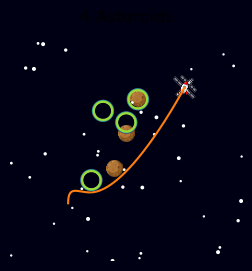

In [23]:
#set initial conditions
t0 = 0
tf = 1
W = 100000
r = (.007,.007)
c1 = (.2,.2)
c2 = (.6,.9)
c3 = (.3,.8)
c4 = (.5,.7)

def ode(t, y_val): #define the ode system
    x, y, xp, yp, p0, p1, p2, p3 = y_val
    #set the new p0 and p1
    new_p0 = obstacle_dx(x,y,W,r,c1) + obstacle_dx(x,y,W,r,c2) + obstacle_dx(x,y,W,r,c3) + obstacle_dx(x,y,W,r,c4)
    new_p1 =  obstacle_dy(x,y,W,r,c1) + obstacle_dy(x,y,W,r,c2) + obstacle_dy(x,y,W,r,c3) + obstacle_dy(x,y,W,r,c4)
    return np.array([xp, yp, p2, p3, new_p0,new_p1, -p0, -p1])

def bc(ya,yb):
# ya are the initial values
# yb are the final values
    return np.array([ya[0],ya[1],ya[2],ya[3]-2,yb[0]-1,yb[1]-1,yb[2],yb[3]])


t_steps = 200 #set the time steps and linspaces
t = np.linspace(t0,tf,t_steps)
x = np.linspace(0,1,t_steps)
y = np.linspace(0,1,t_steps)
X,Y = np.meshgrid(x,y)
#set the asteroids
Z1 = obstacle(X,Y,W,r,c1)
Z2 = obstacle(X,Y,W,r,c2) 
Z3 = obstacle(X,Y,W,r,c3)
Z4 = obstacle(X,Y,W,r,c4)

#set the initial guess
y0 = np.ones((8,t_steps))*3

# Solve the system.
sol = solve_bvp(ode, bc, t, y0,max_nodes=30000)

#plot the solutions and label everything
plt.plot(sol.y[0], sol.y[1])
plt.contour(X,Y,Z1)
plt.contour(X,Y,Z2)
plt.contour(X,Y,Z3)
plt.contour(X,Y,Z4)
plt.axis('off')
plt.title('4 Asteroids')
plt.show()


This finds the solution to the boundary problem.

In [24]:
plt.ioff()

#get data
path_length=len(sol.y[1])
print(path_length)
tail_length=50
ts = range(path_length+50)
fig = plt.figure()
fig.set_facecolor('#000015')
fig.set_size_inches(3, 3)
ax = fig.add_subplot(111)

#set limits
ax.set_xlim([-.5,1.5])
ax.set_ylim([-.5,1.5])
ax.set_facecolor('#000015')

#get path
path=np.vstack((sol.y[0], sol.y[1])).T
rocketpath, = ax.plot([], [],'w', alpha=0.4)

#plot rocket
rocket, = ax.plot([], [], color="#5FC2D9", label='rocket', marker='^', markersize=15)
# ax.legend(prop={'family': 'Arial'})

#plot stars
starx=np.random.uniform(-1,2,size=100)
stary=np.random.uniform(-1,2,size= 100)
sizes=np.random.choice([.5,1,2,3,3.5], size=100)
ax.scatter(starx, stary, s=sizes, color='white')

#asteroid dots
asteroid1 = mpimg.imread("meteoroid.png")
c = [.2,.2]
r = .07
ax.imshow(asteroid1, extent=[c[0]-r, c[0]+r, c[1]-r, c[1]+r])
c = [.6,.9]
r = .07
ax.imshow(asteroid1, extent=[c[0]-r, c[0]+r, c[1]-r, c[1]+r])
c = [.3,.8]
r = .07
ax.imshow(asteroid1, extent=[c[0]-r, c[0]+r, c[1]-r, c[1]+r])
c = [.5,.7]
r = .07
ax.imshow(asteroid1, extent=[c[0]-r, c[0]+r, c[1]-r, c[1]+r])

#plot the space stations
ax.imshow(space_station, extent=[.9,1.1,.9,1.1])

#set dimensions for the rocket
xmin, xmax = sol.y[0][0]-ROCKET_SIZE, sol.y[0][0]+ROCKET_SIZE
ymin, ymax = sol.y[1][0]-ROCKET_SIZE, sol.y[1][0]+ROCKET_SIZE
img = mpimg.imread(filepath)

# plot the trajectory
line, = plt.gca().plot([], [], "--", linewidth=3,)

# Plot initial position of the rocket
rocket = plt.imshow(img, extent=[xmin,xmax,ymin,ymax], aspect='auto', zorder=2)

def update(t):
    if t<tail_length:
        s=0
        p=t
    elif t>path_length-1:
        p=path_length-1
        s=t-tail_length
    else:
        s=t-tail_length
        p=t
    #update path
    rocketpath.set_data(path[s:p,0],path[s:p,1])
    
    #update rocket
    rocket.set_data(rotate_rocket(sol.y[2][t],sol.y[3][t]))
    rocket.set_extent([sol.y[0][t] - ROCKET_SIZE, sol.y[0][t] + ROCKET_SIZE, sol.y[1][t] - ROCKET_SIZE, sol.y[1][t] + ROCKET_SIZE])

#save and show
ani = FuncAnimation(fig, update, frames=ts[:1050][::10], interval=20)
ani.save('rocket_4asteroids.mp4')

1051


This compiles the animation.

<video src="rocket_4asteroids.mp4" controls>

### Model 5

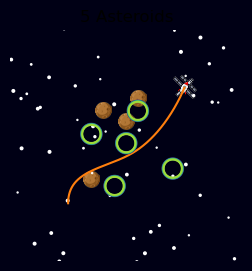

In [25]:
#set the initial conditions
t0 = 0
tf = 1
W = 10000
r = (.007,.007)
c1 = (.4,.15)
c2 = (.6,.8)
c3 = (.9,.3)
c4 = (.5,.52)
c5 = (.2,.6)

def ode(t, y_val): #define the ode system
    x, y, xp, yp, p0, p1, p2, p3 = y_val
    #find the new p0 and p1
    new_p0 = obstacle_dx(x,y,W,r,c4) + obstacle_dx(x,y,W,r,c2) + obstacle_dx(x,y,W,r,c3) + obstacle_dx(x,y,W,r,c1) + obstacle_dx(x,y,W,r,c5)
    new_p1 =  obstacle_dy(x,y,W,r,c4) + obstacle_dy(x,y,W,r,c2) + obstacle_dy(x,y,W,r,c3) + obstacle_dy(x,y,W,r,c1) + obstacle_dy(x,y,W,r,c5)
    return np.array([xp, yp, p2, p3, new_p0, new_p1, -p0, -p1])

def bc(ya,yb):
    # ya are the initial values
    # yb are the final values
    return np.array([ya[0],ya[1],ya[2],ya[3]-2,yb[0]-1,yb[1]-1,yb[2],yb[3]])


t_steps = 200 #set the time steps and linspaces
t = np.linspace(t0,tf,t_steps)
x = np.linspace(0,1,t_steps)
y = np.linspace(0,1,t_steps)
X,Y = np.meshgrid(x,y)
#get all the asteroids
Z1 = obstacle(X,Y,W,r,c1) 
Z2 = obstacle(X,Y,W,r,c2) 
Z3 = obstacle(X,Y,W,r,c3)
Z4 = obstacle(X,Y,W,r,c4)
Z5 = obstacle(X,Y,W,r,c5)
#set initial guess
y0 = np.ones((8,t_steps))*3
# Solve the system.
sol = solve_bvp(ode, bc, t, y0,max_nodes=30000)

#plot the solutions and label everything
plt.plot(sol.y[0], sol.y[1])
plt.contour(X,Y,Z1)
plt.contour(X,Y,Z2)
plt.contour(X,Y,Z3)
plt.contour(X,Y,Z4)
plt.contour(X,Y,Z5)
plt.axis('off')
plt.title('5 Asteroids')
plt.show()

This finds the solution to the boundary problem.

In [26]:
mypath = sol.y
plt.ioff()
#get data
path_length=len(mypath[1])
tail_length=50
ts = range(path_length+50)
fig = plt.figure()
fig.set_facecolor('#000015')
fig.set_size_inches(3, 3)
ax = fig.add_subplot(111)

#set limits
ax.set_xlim([-.5,1.5])
ax.set_ylim([-.5,1.5])
ax.set_facecolor('#000015')

#get path
path=np.vstack((mypath[0], mypath[1])).T
rocketpath, = ax.plot([], [],'w', alpha=0.4)

#plot rocket
rocket, = ax.plot([], [], color="#5FC2D9", label='rocket', marker='^', markersize=15)

#plot stars
starx=np.random.uniform(-1,2,size=100)
stary=np.random.uniform(-1,2,size= 100)
sizes=np.random.choice([.5,1,2,3,3.5], size=100)
ax.scatter(starx, stary, s=sizes, color='white')

#asteroid dots
asteroid1 = mpimg.imread("meteoroid.png")
r = .07
ax.imshow(asteroid1, extent=[c1[0]-r, c1[0]+r, c1[1]-r, c1[1]+r])
ax.imshow(asteroid1, extent=[c2[0]-r, c2[0]+r, c2[1]-r, c2[1]+r])
ax.imshow(asteroid1, extent=[c3[0]-r, c3[0]+r, c3[1]-r, c3[1]+r])
ax.imshow(asteroid1, extent=[c4[0]-r, c4[0]+r, c4[1]-r, c4[1]+r])
ax.imshow(asteroid1, extent=[c5[0]-r, c5[0]+r, c5[1]-r, c5[1]+r])

#show space stations
space_station = mpimg.imread("space-station.png")
ax.imshow(space_station, extent=[.9,1.1,.9,1.1])

#set dimesnios for the rocket
xmin, xmax = sol.y[0][0]-ROCKET_SIZE, sol.y[0][0]+ROCKET_SIZE
ymin, ymax = sol.y[1][0]-ROCKET_SIZE, sol.y[1][0]+ROCKET_SIZE
img = mpimg.imread(filepath)

# plot the trajectory
line, = plt.gca().plot([], [], "--", linewidth=3,)

# Plot initial position of the rocket
rocket = plt.imshow(img, extent=[xmin,xmax,ymin,ymax], aspect='auto', zorder=2)

def update(t):
    if t<tail_length:
        s=0
        p=t
    elif t>path_length-1:
        p=path_length-1
        s=t-tail_length
    else:
        s=t-tail_length
        p=t
    #update path
    rocketpath.set_data(path[s:p,0],path[s:p,1])
    #update rocket
    rocket.set_data(rotate_rocket(sol.y[2][t],sol.y[3][t]))
    rocket.set_extent([sol.y[0][t] - ROCKET_SIZE, sol.y[0][t] + ROCKET_SIZE, sol.y[1][t] - ROCKET_SIZE, sol.y[1][t] + ROCKET_SIZE])
#save and show
ani = FuncAnimation(fig, update, frames=ts[:1020][::10], interval=10)
ani.save('rocket_5asteroids.mp4')

This compiles the animaiton.

<video src="rocket_5asteroids.mp4" controls>

Now that we have looked at optimal paths with varying amounts of asteroids with successful paths we will showcase how choosing the wrong weights can find an unacceptable path.

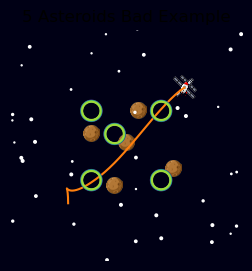

In [27]:
# set initial conditions
t0 = 0
tf = 1
W = 550
r = (.007,.007)
c1 = (.2,.8)
c2 = (.2,.2)
c3 = (.8,.8)
c4 = (.8,.2)
c5 = (.4,.6)

def ode(t, y_val): #define the ode system
    x, y, xp, yp, p0, p1, p2, p3 = y_val
    #find the new p0 and p1
    new_p0 = obstacle_dx(x,y,W,r,c4) + obstacle_dx(x,y,W,r,c2) + obstacle_dx(x,y,W,r,c3) + obstacle_dx(x,y,W,r,c1) + obstacle_dx(x,y,W,r,c5)
    new_p1 =  obstacle_dy(x,y,W,r,c4) + obstacle_dy(x,y,W,r,c2) + obstacle_dy(x,y,W,r,c3) + obstacle_dy(x,y,W,r,c1) + obstacle_dy(x,y,W,r,c5)
    return np.array([xp, yp, p2, p3, new_p0, new_p1, -p0, -p1])

def bc(ya,yb):
# ya are the initial values
# yb are the final values
    return np.array([ya[0],ya[1],ya[2],ya[3]-2,yb[0]-1,yb[1]-1,yb[2],yb[3]])


t_steps = 200 #set the time steps and linspaces
t = np.linspace(t0,tf,t_steps)
x = np.linspace(0,1,t_steps)
y = np.linspace(0,1,t_steps)
X,Y = np.meshgrid(x,y)
#find the obstacles
Z1 = obstacle(X,Y,W,r,c1) 
Z2 = obstacle(X,Y,W,r,c2) 
Z3 = obstacle(X,Y,W,r,c3)
Z4 = obstacle(X,Y,W,r,c4)
Z5 = obstacle(X,Y,W,r,c5)
#set the initial guess
y0 = np.ones((8,t_steps))*1
# Solve the system.
sol = solve_bvp(ode, bc, t, y0,max_nodes=30000)

#plot the solutions and label everything
plt.plot(sol.y[0], sol.y[1])
plt.contour(X,Y,Z1)
plt.contour(X,Y,Z2)
plt.contour(X,Y,Z3)
plt.contour(X,Y,Z4)
plt.contour(X,Y,Z5)
plt.axis('off')
plt.title('5 Asteroids Bad Example')
plt.show()

This finds the solution to the boundary problem.

In [28]:
mypath = sol.y
plt.ioff()

#get data
path_length=len(mypath[1])
tail_length=len(mypath[1]-1)
ts = range(path_length+50)
fig = plt.figure()
fig.set_facecolor('#000015')
fig.set_size_inches(3, 3)
ax = fig.add_subplot(111)

#set limits
ax.set_xlim([-.5,1.5])
ax.set_ylim([-.5,1.5])
ax.set_facecolor('#000015')

#get path
path=np.vstack((mypath[0], mypath[1])).T
rocketpath, = ax.plot([], [],'w', alpha=0.4)

#plot rocket
rocket, = ax.plot([], [], color="#5FC2D9", label='rocket', marker='^', markersize=15)

#plot stars
starx=np.random.uniform(-1,2,size=100)
stary=np.random.uniform(-1,2,size= 100)
sizes=np.random.choice([.5,1,2,3,3.5], size=100)
ax.scatter(starx, stary, s=sizes, color='white')

#asteroid dots
asteroid1 = mpimg.imread("meteoroid.png")
r = .07
ax.imshow(asteroid1, extent=[c1[0]-r, c1[0]+r, c1[1]-r, c1[1]+r])
ax.imshow(asteroid1, extent=[c2[0]-r, c2[0]+r, c2[1]-r, c2[1]+r])
ax.imshow(asteroid1, extent=[c3[0]-r, c3[0]+r, c3[1]-r, c3[1]+r])
ax.imshow(asteroid1, extent=[c4[0]-r, c4[0]+r, c4[1]-r, c4[1]+r])
ax.imshow(asteroid1, extent=[c5[0]-r, c5[0]+r, c5[1]-r, c5[1]+r])

#set space station
space_station = mpimg.imread("space-station.png")
ax.imshow(space_station, extent=[.9,1.1,.9,1.1])

#set title
ax.set_title("Example of Poor Choice of Weights")
ax.set_facecolor('#000015')

#set the dimesions of the spaceship
xmin, xmax = sol.y[0][0]-ROCKET_SIZE, sol.y[0][0]+ROCKET_SIZE
ymin, ymax = sol.y[1][0]-ROCKET_SIZE, sol.y[1][0]+ROCKET_SIZE
img = mpimg.imread(filepath)

# plot the trajectory
line, = plt.gca().plot([], [], "--", linewidth=3,)

# Plot initial position of the rocket
rocket = plt.imshow(img, extent=[xmin,xmax,ymin,ymax], aspect='auto', zorder=2)
ax.set_facecolor('#000015')
def update(t):
    if t<tail_length:
        s=0
        p=t
    elif t>path_length-1:
        p=path_length-1
        s=t-tail_length
    else:
        s=t-tail_length
        p=t
    #update path
    rocketpath.set_data(path[s:p,0],path[s:p,1])
    #update rocket
    rocket.set_data(rotate_rocket(sol.y[2][t],sol.y[3][t]))
    rocket.set_extent([sol.y[0][t] - ROCKET_SIZE, sol.y[0][t] + ROCKET_SIZE, sol.y[1][t] - ROCKET_SIZE, sol.y[1][t] + ROCKET_SIZE])
    
#save and show
ani = FuncAnimation(fig, update, frames=ts[:19000][::100], interval=10)
ani.save('worst_example.mp4')

This compiles the animation.

<video src="worst_example.mp4" controls>

### Model 6

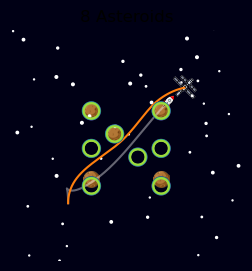

In [29]:
#set initial conditions
t0 = 0
tf = 1
W = 10000
r = (.005,.005)
c1 = (.2,.8)
c2 = (.2,.15)
c3 = (.8,.8)
c4 = (.8,.15)
c5 = (.4,.6)
c6 = (.6,.4)
c7 = (.2,.475)
c8 = (.8,.475)

def ode(t, y_val): #define the ode system
    x, y, xp, yp, p0, p1, p2, p3 = y_val
    #set the new p0 and p1
    new_p0 = obstacle_dx(x,y,W,r,c4) + obstacle_dx(x,y,W,r,c2) + obstacle_dx(x,y,W,r,c3) + obstacle_dx(x,y,W,r,c1) + obstacle_dx(x,y,W,r,c5)+obstacle_dx(x,y,W,r,c6)
    new_p1 =  obstacle_dy(x,y,W,r,c4) + obstacle_dy(x,y,W,r,c2) + obstacle_dy(x,y,W,r,c3) + obstacle_dy(x,y,W,r,c1) + obstacle_dy(x,y,W,r,c5)+obstacle_dy(x,y,W,r,c6)
    return np.array([xp, yp, p2, p3, new_p0, new_p1, -p0, -p1])

def bc(ya,yb):
# ya are the initial values
# yb are the final values
    return np.array([ya[0],ya[1],ya[2],ya[3]-2,yb[0]-1,yb[1]-1,yb[2],yb[3]])


t_steps = 200 #set the time steps and linspaces
t = np.linspace(t0,tf,t_steps)
x = np.linspace(0,1,t_steps)
y = np.linspace(0,1,t_steps)
X,Y = np.meshgrid(x,y)
# set all the asteroids
Z1 = obstacle(X,Y,W,r,c1) 
Z2 = obstacle(X,Y,W,r,c2) 
Z3 = obstacle(X,Y,W,r,c3)
Z4 = obstacle(X,Y,W,r,c4)
Z5 = obstacle(X,Y,W,r,c5)
Z6 = obstacle(X,Y,W,r,c6)
Z7 = obstacle(X,Y,W,r,c7)
Z8 = obstacle(X,Y,W,r,c8)
#set the initial guess
y0 = np.ones((8,t_steps))*1
# Solve the system.
sol = solve_bvp(ode, bc, t, y0,max_nodes=30000)

#plot the solutions and label everything
plt.plot(sol.y[0], sol.y[1])
plt.contour(X,Y,Z1)
plt.contour(X,Y,Z2)
plt.contour(X,Y,Z3)
plt.contour(X,Y,Z4)
plt.contour(X,Y,Z5)
plt.contour(X,Y,Z6)
plt.contour(X,Y,Z7)
plt.contour(X,Y,Z8)
plt.axis('off')
plt.title('8 Asteroids')
plt.show()

This finds the solution to the boundary problem.

In [30]:
mypath = sol.y
plt.ioff()

#get data
path_length=len(mypath[1])
tail_length=50
ts = range(path_length+50)
fig = plt.figure()
fig.set_facecolor('#000015')
fig.set_size_inches(3, 3)
ax = fig.add_subplot(111)

#set limits
ax.set_xlim([-.5,1.5])
ax.set_ylim([-.5,1.5])
ax.set_facecolor('#000015')

#get path
path=np.vstack((mypath[0], mypath[1])).T
rocketpath, = ax.plot([], [],'w', alpha=0.4)

#plot rocket
rocket, = ax.plot([], [], color="#5FC2D9", label='rocket', marker='^', markersize=15)
# ax.legend(prop={'family': 'Arial'})

#plot stars
starx=np.random.uniform(-1,2,size=100)
stary=np.random.uniform(-1,2,size= 100)
sizes=np.random.choice([.5,1,2,3,3.5], size=100)
ax.scatter(starx, stary, s=sizes, color='white')

#asteroid dots
asteroid1 = mpimg.imread("meteoroid.png")
r = .07
ax.imshow(asteroid1, extent=[c1[0]-r, c1[0]+r, c1[1]-r, c1[1]+r])
ax.imshow(asteroid1, extent=[c2[0]-r, c2[0]+r, c2[1]-r, c2[1]+r])
ax.imshow(asteroid1, extent=[c3[0]-r, c3[0]+r, c3[1]-r, c3[1]+r])
ax.imshow(asteroid1, extent=[c4[0]-r, c4[0]+r, c4[1]-r, c4[1]+r])
ax.imshow(asteroid1, extent=[c5[0]-r, c5[0]+r, c5[1]-r, c5[1]+r])
ax.imshow(asteroid1, extent=[c6[0]-r, c6[0]+r, c6[1]-r, c6[1]+r])
ax.imshow(asteroid1, extent=[c7[0]-r, c7[0]+r, c7[1]-r, c7[1]+r])
ax.imshow(asteroid1, extent=[c8[0]-r, c8[0]+r, c8[1]-r, c8[1]+r])

#set space station
space_station = mpimg.imread("space-station.png")
ax.imshow(space_station, extent=[.9,1.1,.9,1.1])

#set dimensions of the rocket
xmin, xmax = sol.y[0][0]-ROCKET_SIZE, sol.y[0][0]+ROCKET_SIZE
ymin, ymax = sol.y[1][0]-ROCKET_SIZE, sol.y[1][0]+ROCKET_SIZE
img = mpimg.imread(filepath)

# plot the trajectory
line, = plt.gca().plot([], [], "--", linewidth=3,)

# Plot initial position of the rocket
rocket = plt.imshow(img, extent=[xmin,xmax,ymin,ymax], aspect='auto', zorder=2)

def update(t):
    if t<tail_length:
        s=0
        p=t
    elif t>path_length-1:
        p=path_length-1
        s=t-tail_length
    else:
        s=t-tail_length
        p=t
    #update path
    rocketpath.set_data(path[s:p,0],path[s:p,1])
    #update rocket
    rocket.set_data(rotate_rocket(sol.y[2][t],sol.y[3][t]))
    rocket.set_extent([sol.y[0][t] - ROCKET_SIZE, sol.y[0][t] + ROCKET_SIZE, sol.y[1][t] - ROCKET_SIZE, sol.y[1][t] + ROCKET_SIZE])

#save and show
ani = FuncAnimation(fig, update, frames=ts[:1320][::10], interval=10)
ani.save('many_asteroids.mp4')

This compiles the animaiton.

<video src="many_asteroids.mp4" controls>

### Model 8

We will now showcase a model with a moving asteroid.

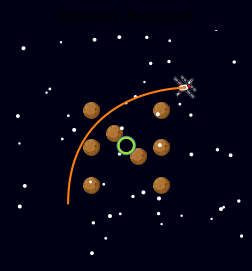

In [31]:
#initialize everything
t0 = 0
tf = 1
W = 10
r = (.005,.005)

def ode(t, y_val): #define the ode system
    x, y, xp, yp, p0, p1, p2, p3 = y_val
    #set the new p0 and p1
    new_p0 = new_obstacle_dx(x,y,t,-.0001,-.0001,W,r)
    new_p1 =  new_obstacle_dy(x,y,t,-.0001,-.0001,W,r)
    return np.array([xp, yp, p2, p3, new_p0,new_p1, -p0, -p1])

def bc(ya,yb):
    # ya are the initial values
    # yb are the final values
    return np.array([ya[0],ya[1],ya[2],ya[3]-3,yb[0]-1,yb[1]-1,yb[2],yb[3]])


t_steps = 200 #set the time steps and linspaces
t = np.linspace(t0,tf,t_steps)
x = np.linspace(0,1,t_steps)
y = np.linspace(0,1,t_steps)
X,Y = np.meshgrid(x,y)

#find the asteroid
Z = obstacle(X,Y,W,r) 

#set the initial guess
y0 = np.ones((8,t_steps))*3

# Solve the system.
sol = solve_bvp(ode, bc, t, y0,max_nodes=30000)

#plot the solutions and label everything
plt.plot(sol.y[0], sol.y[1])
plt.contour(X,Y,Z)
plt.axis('off')
plt.title('Moving Asteroid')
plt.show()


This finds the solution to the boundary problem.

In [32]:
plt.ioff()

#get data
path_length=len(sol.y[1])
print(path_length)
ts = range(path_length+50)
fig = plt.figure()
fig.set_facecolor('#000015')
fig.set_size_inches(3,3)
ax = fig.add_subplot(111)

#set limits
ax.set_xlim([-.5,1.5])
ax.set_ylim([-.5,1.5])
ax.set_facecolor('#000015')

path=np.vstack((sol.y[0], sol.y[1])).T
rocketpath, = ax.plot([], [],'w', alpha=0.4)

#plot rocket
rocket, = ax.plot([], [], color="#5FC2D9", label='rocket', marker='^', markersize=15)

#plot stars
starx=np.random.uniform(-1,2,size=100)
stary=np.random.uniform(-1,2,size= 100)
sizes=np.random.choice([.5,1,2,3,3.5], size=100)
ax.scatter(starx, stary, s=sizes, color='white')

#asteroid dots
asteroid1 = mpimg.imread("meteoroid.png")
asteroid, = ax.plot([], [], color="#5FC2D9", label='asteroid', marker='^', markersize=15)
c = [1/2,1/2]
r = .2

#plot the space stations
space_station = mpimg.imread("space-station.png")
ax.imshow(space_station, extent=[.9,1.1,.9,1.1])

#set the dimensions for the rocket
xmin, xmax = sol.y[0][0]-ROCKET_SIZE, sol.y[0][0]+ROCKET_SIZE
ymin, ymax = sol.y[1][0]-ROCKET_SIZE, sol.y[1][0]+ROCKET_SIZE
img = mpimg.imread(filepath)

# plot the trajectory
line, = plt.gca().plot([], [], "--", linewidth=3,)

# Plot initial position of the rocket
rocket = plt.imshow(img, extent=[xmin,xmax,ymin,ymax], aspect='auto', zorder=2)
asteroid = ax.imshow(asteroid1, extent=[c[0]-r, c[0]+r, c[1]-r, c[1]+r],aspect='auto', zorder=2)
W = 10
r = (.005,.005)

def update(t):
    if t<50:
        s=0
        p=t
    elif t>path_length-1:
        p=path_length-1
        s=t-50
    else:
        s=t-50
        p=t
    #update path
    rocketpath.set_data(path[s:p,0],path[s:p,1])
    #update rocket
    rocket.set_data(rotate_rocket(sol.y[2][t],sol.y[3][t]))
    rocket.set_extent([sol.y[0][t] - ROCKET_SIZE, sol.y[0][t] + ROCKET_SIZE, sol.y[1][t] - ROCKET_SIZE, sol.y[1][t] + ROCKET_SIZE])
    x,y = sol.y[0][t], sol.y[1][t]
    newx,newy = new_obstaclexy(x,y,t,-.0001,-.0001,W,r)
    asteroid.set_extent([newx - ROCKET_SIZE, newx + ROCKET_SIZE, newy - ROCKET_SIZE, newy + ROCKET_SIZE])
    
#save and show
ani = FuncAnimation(fig, update, frames=ts[:200][::2], interval=20)
ani.save('rocketmoving.mp4')

200


This compiles the animation.

<video src="rocketmoving.mp4" controls>

# Results/Analysis

While doing this project we noticed some interesting things that are worth noting. First, when the weights for asteroids are high enough, our model reliable finds the 2-dimensional optimal path to the spaceship in the given amount of time while avoiding asteroids, both moving and stationary. This suggests our model was set up and implemented correctly. We also noticed that the rocket tends to slow down dramatically when it is near an asteroid. This is likely because the cost of being so close to the asteroid is incredibly high, leading the model to drop acceleration dramatically to being the overall cost down. When it moves away from the asteroids, it accelerates quickly and maintains what appears to be a constant velocity to avoid further acceleration and keep the cost down.

# Ethical Considerations

This project doesn't seem to come with an abundance of issues, but there are a few things that should be considered. First, this model is by no means in a state to be applied to the real world at this time. As mentioned previously, there are vast simplifications in this model to better fit our understanding. Disregarding that we are working in a 2-dimensional space, putting a person into our rocket would almost surely seriously harm or kill them, given the aggressive turns and acceleration. This is by far the most important thing to consider before implementing this model into the real world.

# Conclusion

Overall, we have learned a great deal about optimal control through this project. We gained adeeper understanding of how to set up such a problem and edit it in ways to account for more information. There are a variety of ways to complicate this model and make it more realistic in future work. First, more robust application to the 3-dimensional world would be a good place to start. One could also make adjustments to the cost functional in order to account for a variety of things, such as limiting velocity to protect a human inside the spaceship, accounting for gravity, and accounting for the weight of the rocket at how that changes with fuel consumption.

# References

References